In [106]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [107]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [108]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [109]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [110]:
tf.keras.backend.clear_session()

In [111]:
subject = 'Rio Grande Do Sul - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [112]:
data = pd.read_csv('2003_mo_model_input_RS.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rio Grande do Sul - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande Do Sul - Consumo de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - value,Rio Grande do Sul - IDH
0,2003-1,8.192273,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,2.335964,1008.041778,1362.096101,22.905299,17.235207,72.391106,1.662459,135.543840,188.093,2.066295e+08,8.907130e+06,18.206952,1.960625e+08,0.399576,0.775641
1,2003-2,8.186359,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,2.025977,1008.772431,1279.483110,22.138294,16.659273,72.991721,1.632484,134.468148,170.973,2.068579e+08,8.912326e+06,18.211286,1.961183e+08,0.398811,0.775686
2,2003-3,8.180446,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,1.829198,1009.718901,1152.849514,20.909949,15.838093,74.540195,1.615540,134.242963,174.880,2.070864e+08,8.917522e+06,18.215621,1.961742e+08,0.397898,0.775731
3,2003-4,8.174533,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,1.686795,1010.889835,1019.807364,19.370371,14.523610,75.365237,1.576371,133.169391,178.111,2.073148e+08,8.922718e+06,18.219955,1.962300e+08,0.397042,0.775775
4,2003-5,8.168619,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,1.685569,1012.010849,969.329735,17.963807,13.249924,75.732130,1.558359,132.046874,184.331,2.075433e+08,8.927915e+06,18.224290,1.962858e+08,0.396050,0.775820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.410757,1011.466631,1147.109700,17.500897,13.050561,77.226018,1.473291,133.034199,288.217,NaN,NaN,NaN,NaN,0.832392,NaN
260,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.425557,1010.316887,1275.691322,18.825443,13.929853,75.461002,1.549679,133.001080,272.178,NaN,NaN,NaN,NaN,0.829742,NaN
261,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.436442,1009.761024,1337.146179,19.573501,14.454208,74.662726,1.586867,133.052788,272.665,NaN,NaN,NaN,NaN,0.826925,NaN
262,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.394681,1009.583084,1415.774806,20.187124,14.793416,73.583713,1.608730,132.665535,275.972,NaN,NaN,NaN,NaN,0.823550,NaN


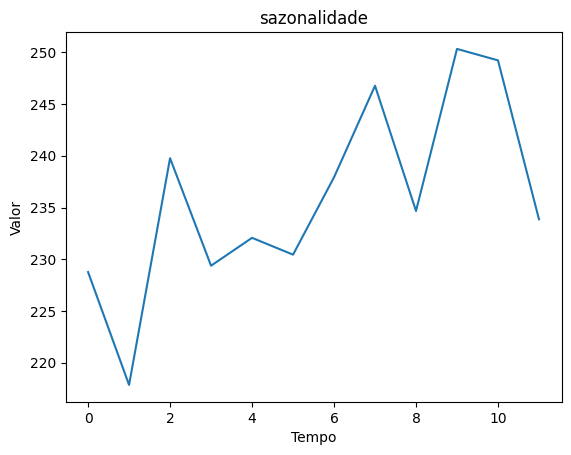

,sazonalidade
sazonalidade,
0,228.76585
1,217.86125
2,239.76200
3,229.37750
4,232.07110
5,230.44500
6,237.91630
7,246.76405
8,234.66495


In [113]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [114]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rio Grande do Sul - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - value,Rio Grande do Sul - IDH,sazonalidade,Rio Grande Do Sul - Consumo de Cimento (t)
0,2003-1,8.192273,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,2.335964,1008.041778,1362.096101,22.905299,17.235207,72.391106,1.662459,135.543840,2.066295e+08,8.907130e+06,18.206952,1.960625e+08,0.399576,0.775641,228.76585,188.093
1,2003-2,8.186359,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,2.025977,1008.772431,1279.483110,22.138294,16.659273,72.991721,1.632484,134.468148,2.068579e+08,8.912326e+06,18.211286,1.961183e+08,0.398811,0.775686,217.86125,170.973
2,2003-3,8.180446,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,1.829198,1009.718901,1152.849514,20.909949,15.838093,74.540195,1.615540,134.242963,2.070864e+08,8.917522e+06,18.215621,1.961742e+08,0.397898,0.775731,239.76200,174.880
3,2003-4,8.174533,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,1.686795,1010.889835,1019.807364,19.370371,14.523610,75.365237,1.576371,133.169391,2.073148e+08,8.922718e+06,18.219955,1.962300e+08,0.397042,0.775775,229.37750,178.111
4,2003-5,8.168619,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,1.685569,1012.010849,969.329735,17.963807,13.249924,75.732130,1.558359,132.046874,2.075433e+08,8.927915e+06,18.224290,1.962858e+08,0.396050,0.775820,232.07110,184.331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.410757,1011.466631,1147.109700,17.500897,13.050561,77.226018,1.473291,133.034199,NaN,NaN,NaN,NaN,0.832392,NaN,246.76405,288.217
260,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.425557,1010.316887,1275.691322,18.825443,13.929853,75.461002,1.549679,133.001080,NaN,NaN,NaN,NaN,0.829742,NaN,234.66495,272.178
261,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.436442,1009.761024,1337.146179,19.573501,14.454208,74.662726,1.586867,133.052788,NaN,NaN,NaN,NaN,0.826925,NaN,250.31965,272.665
262,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.394681,1009.583084,1415.774806,20.187124,14.793416,73.583713,1.608730,132.665535,NaN,NaN,NaN,NaN,0.823550,NaN,249.21435,275.972


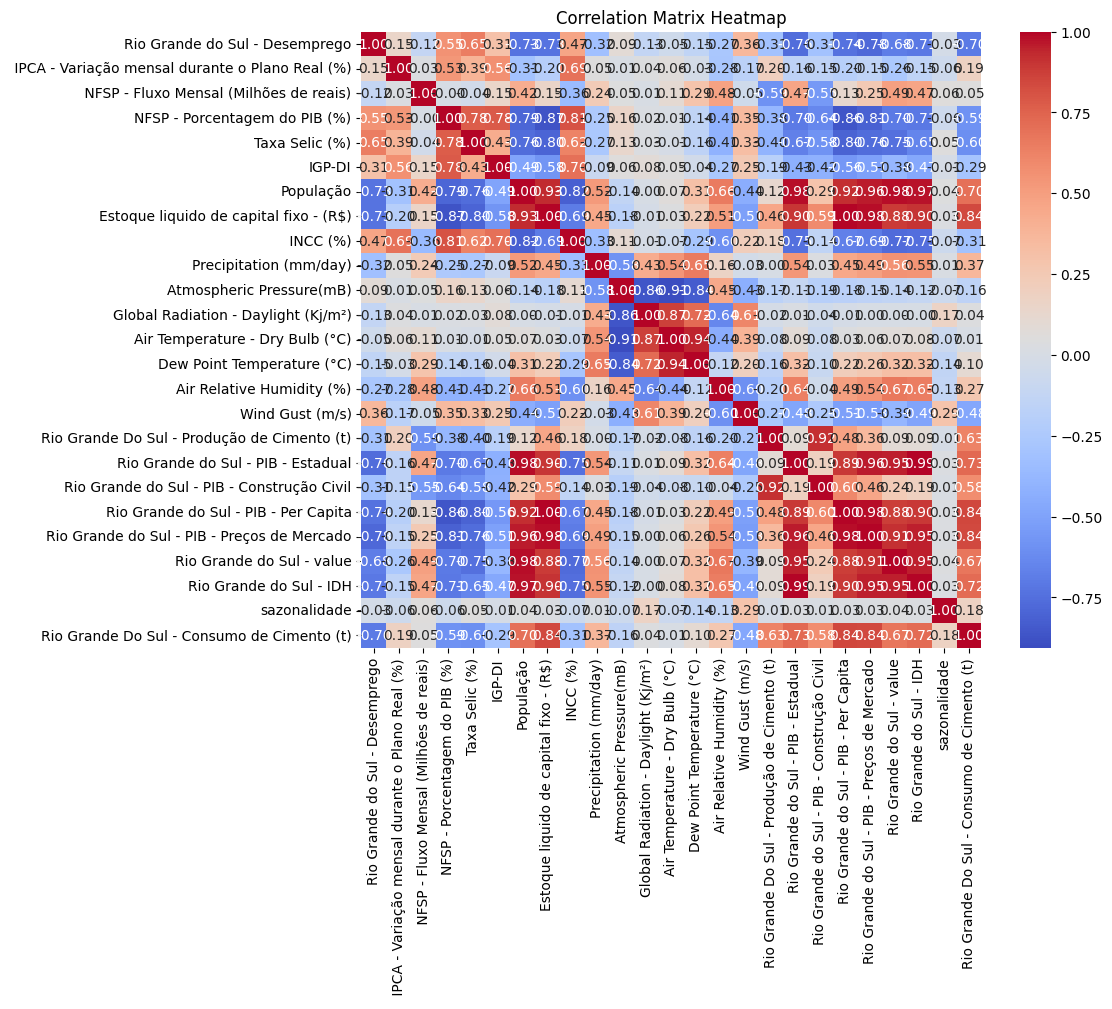

In [115]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [116]:
data =data.drop(['Global Radiation - Daylight (Kj/m²)',
                 ' NFSP - Fluxo Mensal (Milhões de reais)',
                 'Air Temperature - Dry Bulb (°C)', 
                 'Dew Point Temperature (°C)'], axis=1)
data

,Unnamed: 0,Rio Grande do Sul - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - value,Rio Grande do Sul - IDH,sazonalidade,Rio Grande Do Sul - Consumo de Cimento (t)
0,2003-1,8.192273,0.724032,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,2.335964,1008.041778,72.391106,1.662459,135.543840,2.066295e+08,8.907130e+06,18.206952,1.960625e+08,0.399576,0.775641,228.76585,188.093
1,2003-2,8.186359,0.690297,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,2.025977,1008.772431,72.991721,1.632484,134.468148,2.068579e+08,8.912326e+06,18.211286,1.961183e+08,0.398811,0.775686,217.86125,170.973
2,2003-3,8.180446,0.669681,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,1.829198,1009.718901,74.540195,1.615540,134.242963,2.070864e+08,8.917522e+06,18.215621,1.961742e+08,0.397898,0.775731,239.76200,174.880
3,2003-4,8.174533,0.660494,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,1.686795,1010.889835,75.365237,1.576371,133.169391,2.073148e+08,8.922718e+06,18.219955,1.962300e+08,0.397042,0.775775,229.37750,178.111
4,2003-5,8.168619,0.648337,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,1.685569,1012.010849,75.732130,1.558359,132.046874,2.075433e+08,8.927915e+06,18.224290,1.962858e+08,0.396050,0.775820,232.07110,184.331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.410757,1011.466631,77.226018,1.473291,133.034199,NaN,NaN,NaN,NaN,0.832392,NaN,246.76405,288.217
260,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.425557,1010.316887,75.461002,1.549679,133.001080,NaN,NaN,NaN,NaN,0.829742,NaN,234.66495,272.178
261,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.436442,1009.761024,74.662726,1.586867,133.052788,NaN,NaN,NaN,NaN,0.826925,NaN,250.31965,272.665
262,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.394681,1009.583084,73.583713,1.608730,132.665535,NaN,NaN,NaN,NaN,0.823550,NaN,249.21435,275.972


In [117]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
input_data

,Rio Grande do Sul - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - value,Rio Grande do Sul - IDH,sazonalidade
0,1.274013,2.723741,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,1.576227,-1.131809,-1.139822,0.756248,-0.577787,-1.677139,-1.973850,-2.280022,-2.069914,-1.362004,-1.691101,-0.787040
1,1.259068,2.350880,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,0.538673,-0.685826,-0.941173,0.574801,-0.629575,-1.660252,-1.934055,-2.253080,-2.045065,-1.371141,-1.675868,-1.986908
2,1.244123,2.123016,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,-0.119963,-0.108112,-0.429024,0.472232,-0.640416,-1.643365,-1.894260,-2.226138,-2.020217,-1.382062,-1.660635,0.422902
3,1.229178,2.021477,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,-0.596598,0.606614,-0.156146,0.235125,-0.692102,-1.626477,-1.854466,-2.199196,-1.995368,-1.392283,-1.645402,-0.719738
4,1.214233,1.887113,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,-0.600701,1.290869,-0.034798,0.126091,-0.746144,-1.609590,-1.814671,-2.172254,-1.970520,-1.404146,-1.630170,-0.423353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-0.966721,-2.010387,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,-0.579375,0.685325,1.754749,1.086637,-1.420132,1.083219,-0.768157,0.374323,0.568222,1.591021,0.807464,1.193359
188,-0.973649,-1.870713,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,-0.398075,-0.052113,1.243169,1.375057,-1.417824,1.070530,-0.760321,0.347418,0.545097,1.635348,0.773102,-0.137943
189,-0.980576,-1.806230,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,-0.092262,-0.510276,0.768508,1.484294,-1.381727,1.057841,-0.752485,0.320513,0.521971,1.689944,0.738739,1.584593
190,-0.987503,-1.727496,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,0.182289,-0.945695,0.485320,1.401656,-1.359803,1.045153,-0.744649,0.293608,0.498846,1.737741,0.704377,1.462974


In [118]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      174.261
1      164.909
2      202.662
3      174.149
4      159.955
        ...   
259        NaN
260        NaN
261        NaN
262        NaN
263        NaN
Name: Rio Grande Do Sul - Consumo de Cimento (t), Length: 264, dtype: float64

In [119]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Rio Grande do Sul - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - value,Rio Grande do Sul - IDH,sazonalidade
0,1.274013,2.723741,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,1.576227,-1.131809,-1.139822,0.756248,-0.577787,-1.677139,-1.973850,-2.280022,-2.069914,-1.362004,-1.691101,-0.787040
1,1.259068,2.350880,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,0.538673,-0.685826,-0.941173,0.574801,-0.629575,-1.660252,-1.934055,-2.253080,-2.045065,-1.371141,-1.675868,-1.986908
2,1.244123,2.123016,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,-0.119963,-0.108112,-0.429024,0.472232,-0.640416,-1.643365,-1.894260,-2.226138,-2.020217,-1.382062,-1.660635,0.422902
3,1.229178,2.021477,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,-0.596598,0.606614,-0.156146,0.235125,-0.692102,-1.626477,-1.854466,-2.199196,-1.995368,-1.392283,-1.645402,-0.719738
4,1.214233,1.887113,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,-0.600701,1.290869,-0.034798,0.126091,-0.746144,-1.609590,-1.814671,-2.172254,-1.970520,-1.404146,-1.630170,-0.423353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,-0.092018,-0.214006,-0.607704,0.043807,-1.233012,1.031384,0.819304,-0.883659,2.068330,-0.633376,1.248940,-0.244843,-0.647118,1.197586,-0.541459,0.739492,0.925913,0.936850,1.430588,-1.986908
158,-0.148891,-0.434717,-0.620523,0.210856,-1.299304,1.042716,0.808136,-0.950771,1.084588,0.364458,1.751305,-0.547209,-0.689363,1.198866,-0.569240,0.731546,0.918346,0.935032,1.419848,0.422902
159,-0.205765,-0.524091,-0.631530,0.107070,-1.248662,1.054049,0.796969,-1.028465,0.834408,0.907809,1.990735,-0.918047,-0.746341,1.200147,-0.597022,0.723600,0.910778,0.935266,1.409108,-0.719738
160,-0.262638,-0.614500,-0.640320,0.392942,-1.068274,1.065381,0.785801,-1.103668,-0.114488,1.513590,2.052326,-1.361634,-0.811207,1.201428,-0.624803,0.715654,0.903211,0.937596,1.398368,-0.423353


In [120]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      174.261
1      164.909
2      202.662
3      174.149
4      159.955
        ...   
157    196.675
158    251.395
159    199.081
160    220.793
161    211.546
Name: Rio Grande Do Sul - Consumo de Cimento (t), Length: 162, dtype: float64

In [121]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [122]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 20)

In [123]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Rio Grande do Sul - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - value,Rio Grande do Sul - IDH,sazonalidade
126,-1.124877,0.888984,-0.460555,-1.048761,-0.368821,0.651397,0.944085,0.045243,-0.224942,1.330736,0.649854,-1.079202,0.966618,0.843865,0.507575,0.979193,1.048843,0.602074,0.845653,0.219813
127,-1.048798,0.954254,-0.440372,-0.649312,-0.328087,0.664707,0.947319,0.061828,0.145695,0.781105,0.277185,-0.408827,0.910075,0.861669,0.468267,0.975275,1.050210,0.631855,0.868562,1.193359
128,-0.972719,1.045217,-0.419247,-0.535369,-0.176031,0.678017,0.950553,0.046225,1.021044,-0.057609,-0.258140,0.008359,0.848166,0.879474,0.428960,0.971356,1.051577,0.662142,0.891471,-0.137943
129,-0.896640,1.176395,-0.397019,-1.288807,-0.113037,0.691327,0.953786,0.032522,1.108291,-0.687376,-0.759032,0.198873,0.792181,0.897278,0.389653,0.967437,1.052943,0.695357,0.914380,1.584593
130,-0.820561,1.303259,-0.376532,-1.507550,-0.022703,0.704637,0.957020,0.042757,0.887663,-1.257693,-1.113537,0.349047,0.728102,0.915082,0.350345,0.963518,1.054310,0.719249,0.937288,1.462974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-0.966721,-2.010387,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,-0.579375,0.685325,1.754749,1.086637,-1.420132,1.083219,-0.768157,0.374323,0.568222,1.591021,0.807464,1.193359
188,-0.973649,-1.870713,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,-0.398075,-0.052113,1.243169,1.375057,-1.417824,1.070530,-0.760321,0.347418,0.545097,1.635348,0.773102,-0.137943
189,-0.980576,-1.806230,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,-0.092262,-0.510276,0.768508,1.484294,-1.381727,1.057841,-0.752485,0.320513,0.521971,1.689944,0.738739,1.584593
190,-0.987503,-1.727496,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,0.182289,-0.945695,0.485320,1.401656,-1.359803,1.045153,-0.744649,0.293608,0.498846,1.737741,0.704377,1.462974


In [124]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 20)

In [125]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [126]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180,activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [127]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(20)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [128]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1668180562, 2077272452, 3920623094, 923111061, 3619484872, 451832864, 1971549820, 3051459660, 2399804009, 904531381, 3770727774, 3495278036, 1669647280, 870539005, 545890578, 335075657, 507841035, 4279854094, 2428888526, 257150184]


Step: 0 ___________________________________________
val_loss: 83.13089752197266
winner_seed: 1668180562


Step: 1 ___________________________________________
val_loss: 170.0044403076172


Step: 2 ___________________________________________
val_loss: 116.87684631347656


Step: 3 ___________________________________________
val_loss: 194.21463012695312


Step: 4 ___________________________________________
val_loss: 111.62645721435547


Step: 5 ___________________________________________
val_loss: 149.8110809326172


Step: 6 ___________________________________________
val_loss: 138.2493438720703


Step: 7 ___________________________________________
val_loss: 103.76170349121094


Step: 8 ___________________________________________
val_loss: 143.99191284179688


In [129]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 141ms/step - loss: 51166.2070 - val_loss: 1068.1185
Epoch 2/10000
4/4 [==============================] - 0s 17ms/step - loss: 1786.6532 - val_loss: 1084.8384
Epoch 3/10000
4/4 [==============================] - 0s 17ms/step - loss: 1538.7194 - val_loss: 1160.6454
Epoch 4/10000
4/4 [==============================] - 0s 17ms/step - loss: 1518.0287 - val_loss: 1254.6060
Epoch 5/10000
4/4 [==============================] - 0s 16ms/step - loss: 1536.1376 - val_loss: 1304.7561
Epoch 6/10000
4/4 [==============================] - 0s 14ms/step - loss: 1867.2505 - val_loss: 2287.7266
Epoch 7/10000
4/4 [==============================] - 0s 16ms/step - loss: 1612.3682 - val_loss: 941.3941
Epoch 8/10000
4/4 [==============================] - 0s 15ms/step - loss: 1331.4025 - val_loss: 903.9748
Epoch 9/10000
4/4 [==============================] - 0s 14ms/step - loss: 1580.9843 - val_loss: 805.1428
Epoch 10/10000
4/4 [===========================

Epoch 79/10000
4/4 [==============================] - 0s 15ms/step - loss: 391.2295 - val_loss: 229.9451
Epoch 80/10000
4/4 [==============================] - 0s 15ms/step - loss: 397.6789 - val_loss: 209.9043
Epoch 81/10000
4/4 [==============================] - 0s 14ms/step - loss: 349.4355 - val_loss: 253.9453
Epoch 82/10000
4/4 [==============================] - 0s 15ms/step - loss: 387.6812 - val_loss: 236.9677
Epoch 83/10000
4/4 [==============================] - 0s 16ms/step - loss: 344.0338 - val_loss: 196.4999
Epoch 84/10000
4/4 [==============================] - 0s 16ms/step - loss: 311.6953 - val_loss: 326.1913
Epoch 85/10000
4/4 [==============================] - 0s 15ms/step - loss: 276.1854 - val_loss: 243.7240
Epoch 86/10000
4/4 [==============================] - 0s 16ms/step - loss: 280.8281 - val_loss: 233.8532
Epoch 87/10000
4/4 [==============================] - 0s 16ms/step - loss: 314.7883 - val_loss: 234.3294
Epoch 88/10000
4/4 [==============================] - 0

4/4 [==============================] - 0s 13ms/step - loss: 186.9104 - val_loss: 293.9884
Epoch 157/10000
4/4 [==============================] - 0s 15ms/step - loss: 213.2331 - val_loss: 133.2605
Epoch 158/10000
4/4 [==============================] - 0s 17ms/step - loss: 167.1052 - val_loss: 151.9642
Epoch 159/10000
4/4 [==============================] - 0s 14ms/step - loss: 204.8850 - val_loss: 166.7614
Epoch 160/10000
4/4 [==============================] - 0s 13ms/step - loss: 219.9032 - val_loss: 130.6716
Epoch 161/10000
4/4 [==============================] - 0s 16ms/step - loss: 189.7408 - val_loss: 145.5907
Epoch 162/10000
4/4 [==============================] - 0s 16ms/step - loss: 188.0914 - val_loss: 147.5305
Epoch 163/10000
4/4 [==============================] - 0s 12ms/step - loss: 193.0784 - val_loss: 150.5970
Epoch 164/10000
4/4 [==============================] - 0s 13ms/step - loss: 220.7123 - val_loss: 277.0615
Epoch 165/10000
4/4 [==============================] - 0s 13ms

4/4 [==============================] - 0s 13ms/step - loss: 131.4058 - val_loss: 148.2880
Epoch 234/10000
4/4 [==============================] - 0s 16ms/step - loss: 155.2868 - val_loss: 227.5805
Epoch 235/10000
4/4 [==============================] - 0s 16ms/step - loss: 250.0347 - val_loss: 187.7756
Epoch 236/10000
4/4 [==============================] - 0s 15ms/step - loss: 242.9082 - val_loss: 215.0964
Epoch 237/10000
4/4 [==============================] - 0s 15ms/step - loss: 258.6353 - val_loss: 229.0465
Epoch 238/10000
4/4 [==============================] - 0s 16ms/step - loss: 266.6581 - val_loss: 166.4886
Epoch 239/10000
4/4 [==============================] - 0s 15ms/step - loss: 161.2804 - val_loss: 115.8107
Epoch 240/10000
4/4 [==============================] - 0s 16ms/step - loss: 136.4199 - val_loss: 150.7150
Epoch 241/10000
4/4 [==============================] - 0s 14ms/step - loss: 167.5267 - val_loss: 227.2085
Epoch 242/10000
4/4 [==============================] - 0s 16ms

4/4 [==============================] - 0s 13ms/step - loss: 136.9106 - val_loss: 173.2954
Epoch 311/10000
4/4 [==============================] - 0s 15ms/step - loss: 105.0712 - val_loss: 187.9475
Epoch 312/10000
4/4 [==============================] - 0s 13ms/step - loss: 122.4439 - val_loss: 172.9511
Epoch 313/10000
4/4 [==============================] - 0s 14ms/step - loss: 111.9890 - val_loss: 171.8964
Epoch 314/10000
4/4 [==============================] - 0s 14ms/step - loss: 91.4239 - val_loss: 150.2086
Epoch 315/10000
4/4 [==============================] - 0s 17ms/step - loss: 112.0358 - val_loss: 146.9513
Epoch 316/10000
4/4 [==============================] - 0s 13ms/step - loss: 129.8730 - val_loss: 135.1336
Epoch 317/10000
4/4 [==============================] - 0s 16ms/step - loss: 108.0734 - val_loss: 136.0390
Epoch 318/10000
4/4 [==============================] - 0s 13ms/step - loss: 105.0700 - val_loss: 146.2974
Epoch 319/10000
4/4 [==============================] - 0s 15ms/

Epoch 388/10000
4/4 [==============================] - 0s 16ms/step - loss: 115.7235 - val_loss: 259.6635
Epoch 389/10000
4/4 [==============================] - 0s 16ms/step - loss: 115.3249 - val_loss: 174.3422
Epoch 390/10000
4/4 [==============================] - 0s 13ms/step - loss: 70.2474 - val_loss: 160.8503
Epoch 391/10000
4/4 [==============================] - 0s 16ms/step - loss: 74.9736 - val_loss: 157.0909
Epoch 392/10000
4/4 [==============================] - 0s 17ms/step - loss: 81.8952 - val_loss: 247.0388
Epoch 393/10000
4/4 [==============================] - 0s 16ms/step - loss: 102.2486 - val_loss: 194.9352
Epoch 394/10000
4/4 [==============================] - 0s 17ms/step - loss: 60.2836 - val_loss: 193.3152
Epoch 395/10000
4/4 [==============================] - 0s 16ms/step - loss: 99.2922 - val_loss: 223.7017
Epoch 396/10000
4/4 [==============================] - 0s 14ms/step - loss: 94.5196 - val_loss: 130.0081
Epoch 397/10000
4/4 [==============================]

Epoch 466/10000
4/4 [==============================] - 0s 14ms/step - loss: 64.9806 - val_loss: 171.6790
Epoch 467/10000
4/4 [==============================] - 0s 13ms/step - loss: 74.7755 - val_loss: 268.8934
Epoch 468/10000
4/4 [==============================] - 0s 13ms/step - loss: 109.5575 - val_loss: 172.1560
Epoch 469/10000
4/4 [==============================] - 0s 11ms/step - loss: 55.5992 - val_loss: 179.7185
Epoch 470/10000
4/4 [==============================] - 0s 12ms/step - loss: 75.3898 - val_loss: 236.6461
Epoch 471/10000
4/4 [==============================] - 0s 12ms/step - loss: 91.8387 - val_loss: 210.7974
Epoch 472/10000
4/4 [==============================] - 0s 13ms/step - loss: 75.8132 - val_loss: 209.5774
Epoch 473/10000
4/4 [==============================] - 0s 14ms/step - loss: 66.1097 - val_loss: 182.5222
Epoch 474/10000
4/4 [==============================] - 0s 13ms/step - loss: 76.9341 - val_loss: 193.3959
Epoch 475/10000
4/4 [==============================] -

4/4 [==============================] - 0s 16ms/step - loss: 80.1032 - val_loss: 208.9159
Epoch 545/10000
4/4 [==============================] - 0s 17ms/step - loss: 64.2533 - val_loss: 210.5055
Epoch 546/10000
4/4 [==============================] - 0s 16ms/step - loss: 80.7723 - val_loss: 186.5812
Epoch 547/10000
4/4 [==============================] - 0s 18ms/step - loss: 64.1723 - val_loss: 187.5875
Epoch 548/10000
4/4 [==============================] - 0s 16ms/step - loss: 63.9123 - val_loss: 191.9462
Epoch 549/10000
4/4 [==============================] - 0s 16ms/step - loss: 57.6692 - val_loss: 206.1271
Epoch 550/10000
4/4 [==============================] - 0s 15ms/step - loss: 65.1889 - val_loss: 254.8339
Epoch 551/10000
4/4 [==============================] - 0s 15ms/step - loss: 81.6227 - val_loss: 157.8695
Epoch 552/10000
4/4 [==============================] - 0s 15ms/step - loss: 56.4822 - val_loss: 164.2158
Epoch 553/10000
4/4 [==============================] - 0s 14ms/step - l

4/4 [==============================] - 0s 15ms/step - loss: 60.0034 - val_loss: 149.0787
Epoch 623/10000
4/4 [==============================] - 0s 14ms/step - loss: 63.5047 - val_loss: 168.2739
Epoch 624/10000
4/4 [==============================] - 0s 14ms/step - loss: 49.5620 - val_loss: 185.0904
Epoch 625/10000
4/4 [==============================] - 0s 15ms/step - loss: 60.2543 - val_loss: 216.6114
Epoch 626/10000
4/4 [==============================] - 0s 15ms/step - loss: 51.9907 - val_loss: 166.2288
Epoch 627/10000
4/4 [==============================] - 0s 15ms/step - loss: 52.8163 - val_loss: 206.8897
Epoch 628/10000
4/4 [==============================] - 0s 14ms/step - loss: 43.5669 - val_loss: 204.4348
Epoch 629/10000
4/4 [==============================] - 0s 15ms/step - loss: 45.5319 - val_loss: 211.5805
Epoch 630/10000
4/4 [==============================] - 0s 13ms/step - loss: 51.5529 - val_loss: 225.7197
Epoch 631/10000
4/4 [==============================] - 0s 15ms/step - l

4/4 [==============================] - 0s 14ms/step - loss: 39.7302 - val_loss: 177.2339
Epoch 701/10000
4/4 [==============================] - 0s 15ms/step - loss: 46.7568 - val_loss: 174.9769
Epoch 702/10000
4/4 [==============================] - 0s 16ms/step - loss: 41.0549 - val_loss: 169.6555
Epoch 703/10000
4/4 [==============================] - 0s 16ms/step - loss: 34.3794 - val_loss: 188.3192
Epoch 704/10000
4/4 [==============================] - 0s 13ms/step - loss: 41.2369 - val_loss: 198.7325
Epoch 705/10000
4/4 [==============================] - 0s 16ms/step - loss: 43.9020 - val_loss: 232.9045
Epoch 706/10000
4/4 [==============================] - 0s 15ms/step - loss: 69.4692 - val_loss: 191.0548
Epoch 707/10000
4/4 [==============================] - 0s 15ms/step - loss: 36.3977 - val_loss: 232.0921
Epoch 708/10000
4/4 [==============================] - 0s 16ms/step - loss: 43.1676 - val_loss: 237.8759
Epoch 709/10000
4/4 [==============================] - 0s 17ms/step - l

4/4 [==============================] - 0s 14ms/step - loss: 36.0063 - val_loss: 179.4523
Epoch 779/10000
4/4 [==============================] - 0s 16ms/step - loss: 28.5679 - val_loss: 181.1355
Epoch 780/10000
4/4 [==============================] - 0s 13ms/step - loss: 42.1297 - val_loss: 183.0869
Epoch 781/10000
4/4 [==============================] - 0s 15ms/step - loss: 31.5868 - val_loss: 178.0185
Epoch 782/10000
4/4 [==============================] - 0s 16ms/step - loss: 32.6310 - val_loss: 184.6203
Epoch 783/10000
4/4 [==============================] - 0s 13ms/step - loss: 27.5055 - val_loss: 183.5304
Epoch 784/10000
4/4 [==============================] - 0s 15ms/step - loss: 31.3784 - val_loss: 182.9424
Epoch 785/10000
4/4 [==============================] - 0s 14ms/step - loss: 34.3568 - val_loss: 198.0668
Epoch 786/10000
4/4 [==============================] - 0s 15ms/step - loss: 28.7029 - val_loss: 195.1114
Epoch 787/10000
4/4 [==============================] - 0s 15ms/step - l

4/4 [==============================] - 0s 14ms/step - loss: 27.2319 - val_loss: 193.0764
Epoch 857/10000
4/4 [==============================] - 0s 16ms/step - loss: 25.4651 - val_loss: 187.9893
Epoch 858/10000
4/4 [==============================] - 0s 15ms/step - loss: 26.7812 - val_loss: 177.4289
Epoch 859/10000
4/4 [==============================] - 0s 16ms/step - loss: 26.3235 - val_loss: 177.6448
Epoch 860/10000
4/4 [==============================] - 0s 15ms/step - loss: 22.1937 - val_loss: 167.4626
Epoch 861/10000
4/4 [==============================] - 0s 15ms/step - loss: 27.4672 - val_loss: 171.6521
Epoch 862/10000
4/4 [==============================] - 0s 14ms/step - loss: 40.0383 - val_loss: 172.7943
Epoch 863/10000
4/4 [==============================] - 0s 17ms/step - loss: 34.5679 - val_loss: 170.1912
Epoch 864/10000
4/4 [==============================] - 0s 16ms/step - loss: 43.3522 - val_loss: 199.1627
Epoch 865/10000
4/4 [==============================] - 0s 14ms/step - l

4/4 [==============================] - 0s 15ms/step - loss: 23.8781 - val_loss: 184.7852
Epoch 935/10000
4/4 [==============================] - 0s 15ms/step - loss: 21.0718 - val_loss: 188.1933
Epoch 936/10000
4/4 [==============================] - 0s 16ms/step - loss: 26.4296 - val_loss: 168.5813
Epoch 937/10000
4/4 [==============================] - 0s 16ms/step - loss: 24.0390 - val_loss: 173.3157
Epoch 938/10000
4/4 [==============================] - 0s 15ms/step - loss: 26.4271 - val_loss: 198.7508
Epoch 939/10000
4/4 [==============================] - 0s 15ms/step - loss: 28.3993 - val_loss: 167.1785
Epoch 940/10000
4/4 [==============================] - 0s 16ms/step - loss: 21.3114 - val_loss: 190.8164
Epoch 941/10000
4/4 [==============================] - 0s 16ms/step - loss: 18.7821 - val_loss: 191.9296
Epoch 942/10000
4/4 [==============================] - 0s 15ms/step - loss: 20.9387 - val_loss: 205.9607
Epoch 943/10000
4/4 [==============================] - 0s 15ms/step - l

4/4 [==============================] - 0s 17ms/step - loss: 38.7245 - val_loss: 191.3962
Epoch 1013/10000
4/4 [==============================] - 0s 15ms/step - loss: 21.5811 - val_loss: 210.9295
Epoch 1014/10000
4/4 [==============================] - 0s 15ms/step - loss: 23.7493 - val_loss: 206.0806
Epoch 1015/10000
4/4 [==============================] - 0s 15ms/step - loss: 23.2298 - val_loss: 204.1545
Epoch 1016/10000
4/4 [==============================] - 0s 15ms/step - loss: 29.9009 - val_loss: 186.1603
Epoch 1017/10000
4/4 [==============================] - 0s 16ms/step - loss: 15.8981 - val_loss: 198.9334
Epoch 1018/10000
4/4 [==============================] - 0s 16ms/step - loss: 27.6109 - val_loss: 182.0412
Epoch 1019/10000
4/4 [==============================] - 0s 14ms/step - loss: 22.5424 - val_loss: 204.3784
Epoch 1020/10000
4/4 [==============================] - 0s 12ms/step - loss: 18.5356 - val_loss: 217.5110
Epoch 1021/10000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 16ms/step - loss: 30.0467 - val_loss: 171.0631
Epoch 1090/10000
4/4 [==============================] - 0s 14ms/step - loss: 28.8267 - val_loss: 176.3940
Epoch 1091/10000
4/4 [==============================] - 0s 14ms/step - loss: 18.6071 - val_loss: 171.6677
Epoch 1092/10000
4/4 [==============================] - 0s 17ms/step - loss: 27.2314 - val_loss: 254.6197
Epoch 1093/10000
4/4 [==============================] - 0s 14ms/step - loss: 32.6001 - val_loss: 183.6566
Epoch 1094/10000
4/4 [==============================] - 0s 12ms/step - loss: 23.5262 - val_loss: 206.6802
Epoch 1095/10000
4/4 [==============================] - 0s 16ms/step - loss: 20.0998 - val_loss: 203.1204
Epoch 1096/10000
4/4 [==============================] - 0s 15ms/step - loss: 28.2603 - val_loss: 205.0240
Epoch 1097/10000
4/4 [==============================] - 0s 14ms/step - loss: 22.9249 - val_loss: 202.9156
Epoch 1098/10000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 14ms/step - loss: 16.3426 - val_loss: 167.0751
Epoch 1167/10000
4/4 [==============================] - 0s 12ms/step - loss: 22.6033 - val_loss: 199.4129
Epoch 1168/10000
4/4 [==============================] - 0s 16ms/step - loss: 12.7396 - val_loss: 185.7473
Epoch 1169/10000
4/4 [==============================] - 0s 13ms/step - loss: 23.9383 - val_loss: 204.6824
Epoch 1170/10000
4/4 [==============================] - 0s 14ms/step - loss: 20.3671 - val_loss: 188.1196
Epoch 1171/10000
4/4 [==============================] - 0s 15ms/step - loss: 16.1981 - val_loss: 187.6948
Epoch 1172/10000
4/4 [==============================] - 0s 15ms/step - loss: 27.4747 - val_loss: 196.2950
Epoch 1173/10000
4/4 [==============================] - 0s 14ms/step - loss: 18.9778 - val_loss: 207.7626
Epoch 1174/10000
4/4 [==============================] - 0s 15ms/step - loss: 20.5565 - val_loss: 233.9104
Epoch 1175/10000
4/4 [==============================] - 0s 16ms

4/4 [==============================] - 0s 16ms/step - loss: 34.7722 - val_loss: 186.1339
Epoch 1244/10000
4/4 [==============================] - 0s 16ms/step - loss: 20.4450 - val_loss: 167.3300
Epoch 1245/10000
4/4 [==============================] - 0s 14ms/step - loss: 37.7530 - val_loss: 165.7969
Epoch 1246/10000
4/4 [==============================] - 0s 16ms/step - loss: 30.7949 - val_loss: 186.4072
Epoch 1247/10000
4/4 [==============================] - 0s 16ms/step - loss: 15.5263 - val_loss: 182.5306
Epoch 1248/10000
4/4 [==============================] - 0s 14ms/step - loss: 24.2138 - val_loss: 184.8634
Epoch 1249/10000
4/4 [==============================] - 0s 15ms/step - loss: 33.6459 - val_loss: 175.3392
Epoch 1250/10000
4/4 [==============================] - 0s 15ms/step - loss: 21.5558 - val_loss: 177.2125
Epoch 1251/10000
4/4 [==============================] - 0s 14ms/step - loss: 27.1924 - val_loss: 175.3801
Epoch 1252/10000
4/4 [==============================] - 0s 15ms

Epoch 1320/10000
4/4 [==============================] - 0s 16ms/step - loss: 228.0634 - val_loss: 143.9462
Epoch 1321/10000
4/4 [==============================] - 0s 14ms/step - loss: 218.3647 - val_loss: 199.7105
Epoch 1322/10000
4/4 [==============================] - 0s 16ms/step - loss: 222.6433 - val_loss: 133.2748
Epoch 1323/10000
4/4 [==============================] - 0s 15ms/step - loss: 262.7986 - val_loss: 303.7246
Epoch 1324/10000
4/4 [==============================] - 0s 14ms/step - loss: 252.7070 - val_loss: 186.3364
Epoch 1325/10000
4/4 [==============================] - 0s 14ms/step - loss: 284.8795 - val_loss: 256.2492
Epoch 1326/10000
4/4 [==============================] - 0s 14ms/step - loss: 248.8685 - val_loss: 152.2147
Epoch 1327/10000
4/4 [==============================] - 0s 14ms/step - loss: 208.2558 - val_loss: 138.9269
Epoch 1328/10000
4/4 [==============================] - 0s 15ms/step - loss: 219.2330 - val_loss: 129.4904
Epoch 1329/10000
4/4 [===============

4/4 [==============================] - 0s 14ms/step - loss: 159.3331 - val_loss: 134.4399
Epoch 1397/10000
4/4 [==============================] - 0s 14ms/step - loss: 174.9953 - val_loss: 124.5862
Epoch 1398/10000
4/4 [==============================] - 0s 15ms/step - loss: 199.2170 - val_loss: 129.8969
Epoch 1399/10000
4/4 [==============================] - 0s 15ms/step - loss: 165.1886 - val_loss: 150.5393
Epoch 1400/10000
4/4 [==============================] - 0s 16ms/step - loss: 150.0260 - val_loss: 154.0426
Epoch 1401/10000
4/4 [==============================] - 0s 17ms/step - loss: 152.7023 - val_loss: 133.1975
Epoch 1402/10000
4/4 [==============================] - 0s 17ms/step - loss: 181.1504 - val_loss: 126.0924
Epoch 1403/10000
4/4 [==============================] - 0s 15ms/step - loss: 172.5821 - val_loss: 180.8913
Epoch 1404/10000
4/4 [==============================] - 0s 15ms/step - loss: 173.9800 - val_loss: 107.9776
Epoch 1405/10000
4/4 [==============================] 

4/4 [==============================] - 0s 13ms/step - loss: 131.4593 - val_loss: 137.0183
Epoch 1473/10000
4/4 [==============================] - 0s 14ms/step - loss: 129.5611 - val_loss: 172.2025
Epoch 1474/10000
4/4 [==============================] - 0s 15ms/step - loss: 116.7487 - val_loss: 131.2767
Epoch 1475/10000
4/4 [==============================] - 0s 14ms/step - loss: 148.2323 - val_loss: 243.2443
Epoch 1476/10000
4/4 [==============================] - 0s 14ms/step - loss: 194.3589 - val_loss: 141.8578
Epoch 1477/10000
4/4 [==============================] - 0s 16ms/step - loss: 149.7706 - val_loss: 124.3753
Epoch 1478/10000
4/4 [==============================] - 0s 14ms/step - loss: 145.0579 - val_loss: 133.9391
Epoch 1479/10000
4/4 [==============================] - 0s 14ms/step - loss: 154.6918 - val_loss: 128.1216
Epoch 1480/10000
4/4 [==============================] - 0s 17ms/step - loss: 122.6176 - val_loss: 223.6663
Epoch 1481/10000
4/4 [==============================] 

4/4 [==============================] - 0s 12ms/step - loss: 139.3559 - val_loss: 133.3964
Epoch 1549/10000
4/4 [==============================] - 0s 12ms/step - loss: 141.9872 - val_loss: 163.3401
Epoch 1550/10000
4/4 [==============================] - 0s 13ms/step - loss: 108.8914 - val_loss: 141.5395
Epoch 1551/10000
4/4 [==============================] - 0s 14ms/step - loss: 123.8199 - val_loss: 280.5873
Epoch 1552/10000
4/4 [==============================] - 0s 13ms/step - loss: 193.8415 - val_loss: 170.5212
Epoch 1553/10000
4/4 [==============================] - 0s 13ms/step - loss: 142.1968 - val_loss: 172.9781
Epoch 1554/10000
4/4 [==============================] - 0s 12ms/step - loss: 130.2825 - val_loss: 205.8701
Epoch 1555/10000
4/4 [==============================] - 0s 13ms/step - loss: 116.3711 - val_loss: 177.3246
Epoch 1556/10000
4/4 [==============================] - 0s 12ms/step - loss: 113.2422 - val_loss: 257.8251
Epoch 1557/10000
4/4 [==============================] 

Epoch 1625/10000
4/4 [==============================] - 0s 15ms/step - loss: 113.4030 - val_loss: 140.5251
Epoch 1626/10000
4/4 [==============================] - 0s 15ms/step - loss: 109.4567 - val_loss: 134.3134
Epoch 1627/10000
4/4 [==============================] - 0s 15ms/step - loss: 114.3504 - val_loss: 148.6786
Epoch 1628/10000
4/4 [==============================] - 0s 14ms/step - loss: 108.9008 - val_loss: 153.7547
Epoch 1629/10000
4/4 [==============================] - 0s 14ms/step - loss: 119.2835 - val_loss: 248.5721
Epoch 1630/10000
4/4 [==============================] - 0s 15ms/step - loss: 120.5512 - val_loss: 148.2026
Epoch 1631/10000
4/4 [==============================] - 0s 14ms/step - loss: 118.5459 - val_loss: 160.0053
Epoch 1632/10000
4/4 [==============================] - 0s 16ms/step - loss: 130.6920 - val_loss: 152.7095
Epoch 1633/10000
4/4 [==============================] - 0s 16ms/step - loss: 110.1522 - val_loss: 205.6286
Epoch 1634/10000
4/4 [===============

4/4 [==============================] - 0s 16ms/step - loss: 154.3660 - val_loss: 340.2955
Epoch 1702/10000
4/4 [==============================] - 0s 16ms/step - loss: 148.5875 - val_loss: 284.1328
Epoch 1703/10000
4/4 [==============================] - 0s 17ms/step - loss: 125.7993 - val_loss: 220.9045
Epoch 1704/10000
4/4 [==============================] - 0s 15ms/step - loss: 97.4626 - val_loss: 196.7605
Epoch 1705/10000
4/4 [==============================] - 0s 16ms/step - loss: 92.7142 - val_loss: 182.3507
Epoch 1706/10000
4/4 [==============================] - 0s 14ms/step - loss: 89.9252 - val_loss: 176.2656
Epoch 1707/10000
4/4 [==============================] - 0s 15ms/step - loss: 101.5323 - val_loss: 264.7776
Epoch 1708/10000
4/4 [==============================] - 0s 14ms/step - loss: 135.7377 - val_loss: 163.6401
Epoch 1709/10000
4/4 [==============================] - 0s 14ms/step - loss: 88.8908 - val_loss: 166.5976
Epoch 1710/10000
4/4 [==============================] - 0s

Epoch 1778/10000
4/4 [==============================] - 0s 13ms/step - loss: 74.8714 - val_loss: 147.8605
Epoch 1779/10000
4/4 [==============================] - 0s 14ms/step - loss: 89.8545 - val_loss: 151.7421
Epoch 1780/10000
4/4 [==============================] - 0s 15ms/step - loss: 88.9476 - val_loss: 145.3930
Epoch 1781/10000
4/4 [==============================] - 0s 15ms/step - loss: 153.2963 - val_loss: 136.3015
Epoch 1782/10000
4/4 [==============================] - 0s 14ms/step - loss: 90.6047 - val_loss: 150.5576
Epoch 1783/10000
4/4 [==============================] - 0s 16ms/step - loss: 81.1613 - val_loss: 151.8017
Epoch 1784/10000
4/4 [==============================] - 0s 15ms/step - loss: 103.4436 - val_loss: 140.9064
Epoch 1785/10000
4/4 [==============================] - 0s 14ms/step - loss: 121.7843 - val_loss: 197.8037
Epoch 1786/10000
4/4 [==============================] - 0s 15ms/step - loss: 139.1519 - val_loss: 114.5448
Epoch 1787/10000
4/4 [====================

Epoch 1855/10000
4/4 [==============================] - 0s 16ms/step - loss: 118.1059 - val_loss: 148.0237
Epoch 1856/10000
4/4 [==============================] - 0s 15ms/step - loss: 92.4920 - val_loss: 195.8864
Epoch 1857/10000
4/4 [==============================] - 0s 15ms/step - loss: 85.4621 - val_loss: 206.6203
Epoch 1858/10000
4/4 [==============================] - 0s 16ms/step - loss: 95.9824 - val_loss: 166.8944
Epoch 1859/10000
4/4 [==============================] - 0s 15ms/step - loss: 102.6854 - val_loss: 142.4796
Epoch 1860/10000
4/4 [==============================] - 0s 15ms/step - loss: 101.3659 - val_loss: 153.5851
Epoch 1861/10000
4/4 [==============================] - 0s 15ms/step - loss: 106.1179 - val_loss: 158.9621
Epoch 1862/10000
4/4 [==============================] - 0s 14ms/step - loss: 119.7182 - val_loss: 256.3255
Epoch 1863/10000
4/4 [==============================] - 0s 14ms/step - loss: 101.6602 - val_loss: 216.7121
Epoch 1864/10000
4/4 [==================

In [130]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [131]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 24ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,231.918808,238.766998,228.77005,237.354706,236.586975,210.382599,207.438278,208.271286,214.800964,211.655167,213.751999,214.596161,220.538269,224.894287,217.654022,216.195099,214.144501,212.12294,217.600159,217.824951,219.580063,215.399719,214.680511,215.105896,216.437042,228.801788,222.395477,208.354477,210.631607,220.843231
Target,244.68,252.183,249.403,208.299,238.414,213.179,221.534,212.139,228.994,226.827,186.855,253.021,194.988,244.406,201.372,251.369,242.782,201.288,226.547,228.5,223.896,234.132,207.586,228.583,234.565,249.519,230.086,233.136,233.8,223.214
Error,12.761185,13.416,20.63295,29.05571,1.827026,2.796402,14.095718,3.867722,14.193039,15.171829,26.897003,38.424835,25.550262,19.511719,16.282028,35.173904,28.637497,10.834946,8.946838,10.675049,4.315933,18.732285,7.094513,13.477097,18.12796,20.717209,7.690521,24.781525,23.168396,2.370773


In [132]:
display(mae)
display(mape)

16.307596

0.071556896

In [133]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input.iloc[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [134]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             test_input, 
                                             test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

NameError: name 'test_target' is not defined